# Predicting Boston Housing Prices

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in Boston, Massachusetts. A decision tree regression model trained on this data that is seen as a good fit could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

## Data Exploration

### Load the libraries and dataset

In [1]:
# Load necessary libraries and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as curves
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats
from scipy.stats import skew,norm

# Make matplotlib show our plots inline (nicely formatted in the notebook)
%matplotlib inline

In [2]:
# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


### Calculate Statistics

In [3]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price)) 
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


### Feature Observation

In [4]:
data.head()

,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


There are three features in the Boston housing dataset: 'RM', 'LSTAT', and 'PTRATIO'.

* 'RM' is the average number of rooms among homes in the neighborhood.
* 'LSTAT' is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
* 'PTRATIO' is the ratio of students to teachers in primary and secondary schools in the neighborhood.

For each of the three features above, here is what I think:

* A home with higher 'RM' value(number of rooms) should have higher price than a home with lower 'RM' value assuming that all of the other features are similar. The reason is it has more value, which is space and functionality.
* Based on experience, the home prices in neighborhood with higher 'LSTAT' value(percent of lower class workers) will be lower than in neighborhood with lower 'LSTAT' value. The reason is more likely due to supply and demand balance. The demand is related with the buying power (income, asset, etc) of the community.
* The home price may not be dependent on 'PTRATIO'. I think the price is driven more by the quality of the school than the number of students. Homes in a neighborhood with good schools will be more expensive than in a neighborhood with mediocre schools.

Let try to evaluate by plotting price vs each feature.

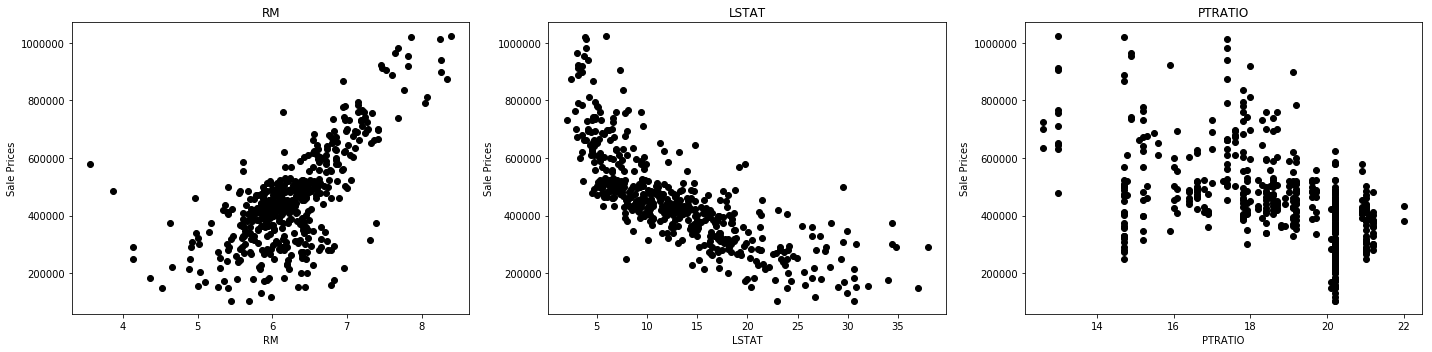

In [5]:
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], prices, 'o', color='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Sale Prices')
    plt.tight_layout()

## Developing Decision Tree Model

### Define a Performance Metric

In [6]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score

### Shuffle and Split Data

In [7]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=42)

### Learning Curve and Model Complexity Functions

The following function produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. The model is scored on both the training and testing sets using R2, the coefficient of determination.

In [8]:
def learning_curves(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = plt.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,4,7,10]):

        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = curves.learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')

        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')

        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    ax.legend(loc='best', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    

The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the learning curves, the model is scored on both the training and validation sets using the performance_metric function.

In [9]:
def model_complexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    plt.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('Score')
    plt.ylim([-0.05,1.05])
    plt.show()

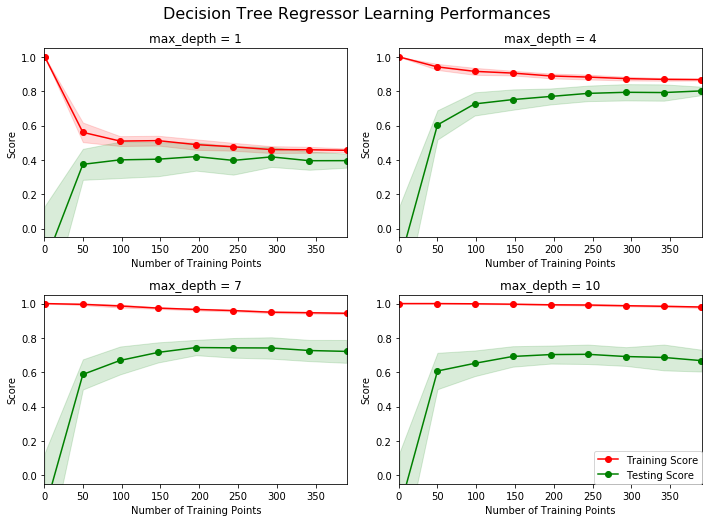

In [10]:
learning_curves(features, prices)

In the learning curve with max_depth of 4, training scores are relatively high and test scores are low when the number of training points are small. As the number of training points increase, both scores converge at about 0.8. In this case, increasing the training points from 50 to 350 benefits the model. More specifically, at low number of training points, the model is overfitting as it does well in predicting the training set, but fail in predicting the test set. At higher number of training points, the overfitting is significantly reduced. Beyond 350 training points, adding new training points may not significantly benefit the model as both curves are close to convergence.

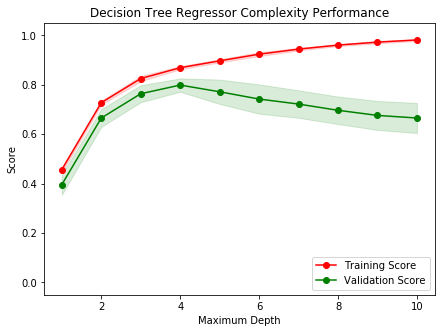

In [11]:
model_complexity(features, prices)

Here is what we can see from the graphs:
* Maximum depth of 4 would result in a model that best generalize to unseen data.
* At maximum depth of lower than 4, the model suffers from underfitting. 
* At maximum depth above 4, we start to see overfitting problem, where the model performs significantly better in training set than in test set.

### Fitting a Model

Let try to fit a model using Grid Search and find out the best value for 'max_depth' parameter

In [12]:
def fit_model_grid(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=88)

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':np.arange(1,11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor,param_grid=params,scoring=scoring_fnc,cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [13]:
# Fit the training data to the model using grid search
reg_grid = fit_model_grid(X_train, y_train)

# Produce the value for 'max_depth'
print("Grid Search - Parameter 'max_depth' is {} for the optimal model.".format(reg_grid.get_params()['max_depth']))

Grid Search - Parameter 'max_depth' is 4 for the optimal model.


The optimum model has maximum depth of 4, exactly the same as we guessed above.

In [14]:
# Model predict
preds_grid = reg_grid.predict(X_test)

In [15]:
# Calculate the performance score between 'y_true' and 'y_predict'
performance_metric(y_test, preds_grid)

0.8439995575360899

Now try to fit a model using Randomized Search and get the parameter 'max_depth'

In [16]:
def fit_model_rand(X, y):
    """ Performs Randomized search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
     # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], test_size = 0.20, random_state = 0)
    
     # Create a decision tree regressor object
    regressor = DecisionTreeRegressor(random_state=88)
    
    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':np.arange(1,11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer'
    # We initially created performance_metric using R2_score
    scoring_fnc = make_scorer(performance_metric)
    
    # Create the randomized search object
    rand = RandomizedSearchCV(regressor, params, cv=cv_sets, scoring=scoring_fnc)
    
    # Fit the grid search object to the data to compute the optimal model
    rand = rand.fit(X, y)
    
    # Return the optimal model after fitting the data
    return rand.best_estimator_

In [17]:
# Fit the training data to the model using grid search
reg_rand = fit_model_rand(X_train, y_train)

# Produce the value for 'max_depth'
print("Randomized Search - Parameter 'max_depth' is {} for the optimal model.".format(reg_rand.get_params()['max_depth']))

Randomized Search - Parameter 'max_depth' is 4 for the optimal model.


In [18]:
# Model predict
preds_rand = reg_rand.predict(X_test)

In [19]:
# Calculate the performance score between 'y_true' and 'y_predict'
performance_metric(y_test, preds_rand)

0.8439995575360899

### Predict The Best Selling Price of Client's Home

In [20]:
# Produce a matrix for client data
CLIENT_FEATURES = [[5, 17, 15], # Client 1
                   [4, 32, 22], # Client 2
                   [8, 3, 12]]  # Client 3

In [22]:
# Show predictions - Grid Search
for i, price in enumerate(reg_grid.predict(CLIENT_FEATURES)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


## Conclusion

I think this model is a quite good model to predict the selling price of future clients' homes in the Boston area. During the implementation, I applied a few methods to improve the accuracy of the predictions, as following: 
(1) cross-validated to ensure accurate performance by taking the average of multiple learning experiences, 
(2) used grid searched and randomized search to find the most suitable parameter,
(3) found the sweet spot between bias and variance by finding the optimal complexity (depth of decision tree) of the model.